<a href="https://colab.research.google.com/github/vsham05/Detection-OCR-HandwritingModel/blob/main/%D0%9F%D0%B5%D1%80%D0%B2%D1%8B%D0%B9%D0%91%D0%98%D0%A2_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Краткая информация**

В данном ноутбуке представлены основные способы обнаружения и распознания рукописного текста на изображении для дальнейшей оцифровки текстов.

Работа выполнена в рамках прохождения практики в компании Первый Бит.

# **Датасеты**

Для создания модели используются датасеты с открытых источников.



*   [Будет добавлено позже](https://)
*   Новый пункт



# **Создание модели детекции рукописного текста**

In [ ]:
!unzip /content/drive/MyDrive/Датасет_на_практику/Russian_Handwritten_Text.v7i.coco.zip

Archive:  /content/drive/MyDrive/Датасет_на_практику/Russian_Handwritten_Text.v7i.coco.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/109_4_JPG.rf.a3ed05c4acb87accc0947f81f09c351a.jpg  
 extracting: test/47_2_JPG.rf.380e4b38f269702ea44966ec862f767b.jpg  
 extracting: test/50_16_JPG.rf.1a3c914b80b2f972246061757fffcc4c.jpg  
 extracting: test/57_2_jpg.rf.6457ae37740a976303f279c363ff0404.jpg  
 extracting: test/63_5_JPG.rf.7bbcc9d0be2c2531002618ef1efe1ea0.jpg  
 extracting: test/81_8_JPG.rf.fb0b35158c883e7a68ecbd2ba3a6360c.jpg  
 extracting: test/91_4_jpg.rf.ee60163e7edd300d539ab30ce5e08838.jpg  
 extracting: test/95_34_JPG.rf.5f1192cf1d93a9ac9d3144ffb04e0b58.jpg  
 extracting: test/99_1_JPG.rf.5d5bc37bd8a73d50881277bcf314dce3.jpg  
 extracting: test/_annotations.coco.json  
   creating: train/
 extracting: train/100_0_JPG.rf.702124c4e426cffa10fe1ab08debd966.jpg  
 extracting: train/100_0_JPG.rf.8c6cb878aef2160e028d9bbe

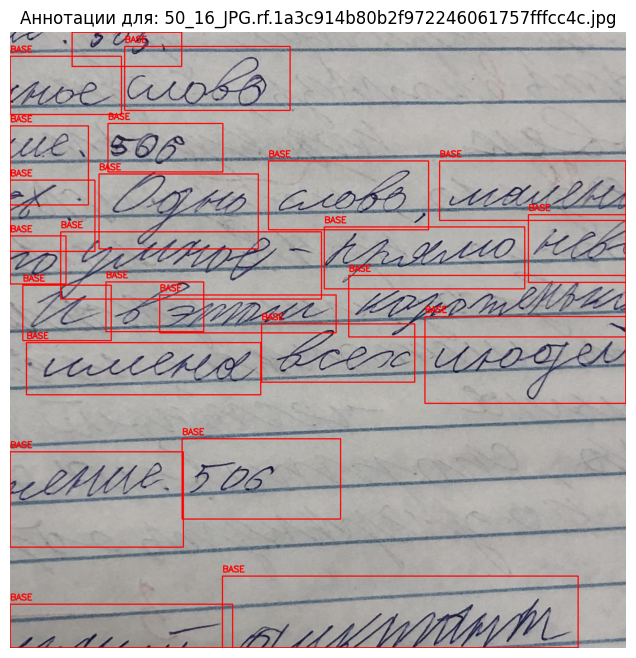

In [ ]:
import json
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def visualize_annotations_for_image(image_path, annotation_path):
    """
    Визуализирует все аннотации (bounding boxes + сегментации) для одной картинки.

    Args:
        image_path (str): Путь к изображению (например, "train/image1.jpg").
        annotation_path (str): Путь к `_annotations.coco.json`.
    """
    # Загружаем аннотации
    with open(annotation_path, 'r') as f:
        coco_data = json.load(f)

    # Находим имя файла (например, "image1.jpg")
    image_filename = os.path.basename(image_path)


    # Ищем информацию о картинке в аннотациях
    image_info = None
    for img in coco_data["images"]:
        if img["file_name"] == image_filename:
            image_info = img
            break

    if not image_info:
        print(f"❌ Изображение {image_filename} не найдено в аннотациях!")
        return

    # Загружаем само изображение
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR → RGB

    # Получаем все аннотации для этой картинки
    annotations = [
        ann for ann in coco_data["annotations"]
        if ann["image_id"] == image_info["id"]
    ]

    # Отрисовываем каждую аннотацию
    for ann in annotations:
        # --- 1. Рисуем Bounding Box ---
        if "bbox" in ann:
            x, y, w, h = map(int, ann["bbox"])
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Синий прямоугольник

        # --- 2. Рисуем сегментацию (полигон) ---
        if "segmentation" in ann:
            for seg in ann["segmentation"]:
                points = np.array(seg, np.int32).reshape((-1, 2))
                cv2.polylines(image, [points], True, (0, 255, 0), 2)  # Зелёный контур

        # --- 3. Подписываем класс объекта ---
        if "category_id" in ann:
            category_id = ann["category_id"]
            category_name = next(
                (cat["name"] for cat in coco_data["categories"] if cat["id"] == category_id),
                str(category_id))
            cv2.putText(
                image, category_name, (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2
            )

    # Показываем результат
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Аннотации для: {image_filename}")
    plt.show()

# Пример использования:
image_path = "/content/test/50_16_JPG.rf.1a3c914b80b2f972246061757fffcc4c.jpg"  # Путь к конкретной картинке
annotation_path = "/content/test/_annotations.coco.json"  # Путь к аннотациям

if os.path.exists(image_path) and os.path.exists(annotation_path):
    visualize_annotations_for_image(image_path, annotation_path)
else:
    print("❌ Файл не найден!")

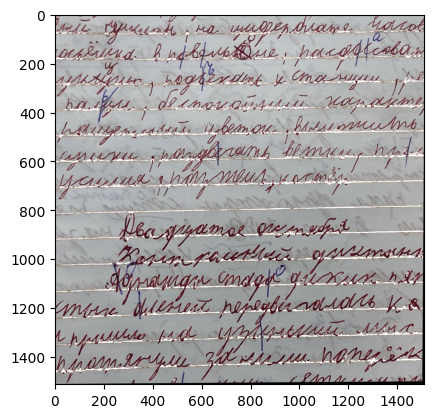

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def upscale_blue(image_path):
    # Load image
    im = cv2.imread(image_path)

    # Define lower and upper limits of our blue
    BlueMin = np.array([100, 50, 20], np.uint8)    # более темные оттенки
    BlueMax = np.array([120, 255, 255], np.uint8)

    # Go to HSV colourspace and get mask of blue pixels
    HSV  = cv2.cvtColor(im,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(HSV, BlueMin, BlueMax)

    # Make all pixels in mask white
    im[mask>0] = [255,255,255]
    return im

def preproccess_data(folder_path):

# Получаем список файлов
    images = [folder_path + '/' + e for e in os.listdir(folder_path) if e.endswith('.jpg')]

    for image in images:



plt.imshow(upscale_blue('/content/train/100_0_JPG.rf.a0857daec964709d5dcdd508bf4fa6f2.jpg'))

In [ ]:
import torch
from torch.utils.data import Dataset
import json
import cv2
import os

class CocoDetectionDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        self.image_ids = [img['id'] for img in self.coco_data['images']]
        self.id_to_img = {img['id']: img for img in self.coco_data['images']}
        self.id_to_anns = {img_id: [] for img_id in self.image_ids}

        for ann in self.coco_data['annotations']:
            self.id_to_anns[ann['image_id']].append(ann)

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.id_to_img[img_id]
        img_path = os.path.join(self.root_dir, img_info['file_name'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        anns = self.id_to_anns[img_id]
        boxes = []
        labels = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])  # COCO: [x,y,w,h] → [x1,y1,x2,y2]
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id])
        }

        if self.transform:
            transformed = self.transform(image=image, bboxes=target['boxes'], labels=target['labels'])
            image = transformed['image']
            target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            target['labels'] = torch.as_tensor(transformed['labels'], dtype=torch.int64)

        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        return image, target

In [ ]:
import os, os.path
# simple version for working with CWD
print(len([name for name in os.listdir('.') if os.path.isfile(name)]))
# path joining version for other paths
DIR = '/content/train'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

2
2479


In [ ]:
from torch.utils.data import DataLoader

# Пути к данным
train_dir = "/content/train"
train_annotations = os.path.join(train_dir, "_annotations.coco.json")

# Создаем датасет
dataset = CocoDetectionDataset(
    root_dir=train_dir,
    annotation_file=train_annotations,
    transform=None,  # Можно добавить аугментации (Albumentations)
)

# Пример загрузки одной картинки
image, target = dataset[0]
print("Image shape:", image.shape)
print("Bounding boxes:", target['boxes'])
print("Labels:", target['labels'])
print(len(dataset))

Image shape: torch.Size([3, 1512, 1512])
Bounding boxes: tensor([[   0.0000,  698.0000,   42.8780,  783.0000],
        [ 126.0000,    0.0000,  479.3610,   31.0000],
        [   0.0000,  122.0000,  192.5800,  171.0000],
        [   0.0000,  351.0000,  165.9160,  483.0000],
        [ 205.0000,  343.0000,  561.7090,  446.0400],
        [  50.0000,  435.0000,  483.9470,  534.4200],
        [   3.0000,  547.0000,  308.7870,  663.6100],
        [ 317.0000,  527.0000,  624.6240,  656.2800],
        [ 629.0000,  542.0000,  843.1610,  658.9500],
        [  73.0000,  733.0000,  530.6880,  845.4400],
        [ 545.0000,  744.0000,  833.1910,  838.6300],
        [   0.0000,  842.0000,  294.2020,  965.0000],
        [ 313.0000,  842.0000,  673.5150,  895.7500],
        [   0.0000, 1086.0000,  251.3630, 1233.0000],
        [ 266.0000, 1108.0000,  606.2750, 1217.6000],
        [   0.0000, 1209.0000,  279.9320, 1347.0000],
        [   0.0000, 1304.0000,  168.8270, 1441.0000],
        [   0.0000, 1420.

In [ ]:
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))  # Для поддержки разного числа объектов в изображениях
)

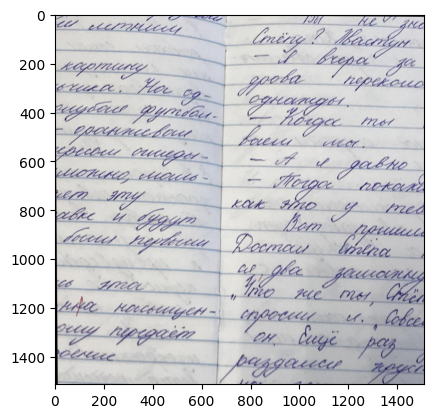

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

image = np.transpose(image, (1, 2, 0))

mask = dataset[1][0]
mask = np.transpose(mask, (1, 2, 0))
plt.imshow(mask, cmap='gray')
plt.show()

In [ ]:
import torch.optim as optim
import torchvision

from torchvision.models.detection import fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(pretrained = True,num_classes=91)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features,
    num_classes=2  # Новое число классов
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
for name, param in model.backbone.body.named_parameters():
    if "layer1" in name or "layer2" in name or "layer3" in name:
        param.requires_grad = False


optimizer = optim.Adam(model.parameters(), lr=0.001)

dataset = CocoDetectionDataset('train', 'train/_annotations.coco.json')
dataloader = DataLoader(dataset, batch_size=17, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

for epoch in range(10):
    print(epoch)
    for images, targets in dataloader:
        if any(len(t["boxes"]) == 0 for t in targets):
            continue
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {losses.item()}')

0
Epoch 0, Loss: 1.3756780624389648
1
Epoch 1, Loss: 1.2215510606765747
2
Epoch 2, Loss: 1.0694849491119385
3
Epoch 3, Loss: 1.0083197355270386
4
Epoch 4, Loss: 0.8384548425674438
5
Epoch 5, Loss: 0.8679234385490417
6
Epoch 6, Loss: 0.8130332231521606
7
Epoch 7, Loss: 0.8319705128669739
8
Epoch 8, Loss: 0.7663624286651611
9
Epoch 9, Loss: 0.7080318927764893


[{'boxes': tensor([[706.6168, 390.4359, 734.5115, 414.0470],
        [737.2168, 392.4649, 783.9669, 432.9672],
        [362.9307,  93.2357, 402.5036, 113.9519],
        [382.3099,  93.2702, 403.1257, 104.8573]]), 'labels': tensor([16, 16, 16, 16]), 'scores': tensor([0.1518, 0.0610, 0.0549, 0.0538])}]


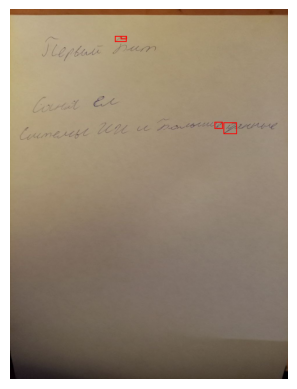

In [ ]:
from PIL import Image, ImageDraw
import torch
import torchvision
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt

# 1. Загрузка изображения через PIL
image_path = "/content/1.jpg"
image = Image.open(image_path).convert("RGB")  # Конвертируем в RGB

# 2. Преобразование в тензор для PyTorch
image_tensor = F.to_tensor(image)  # Автоматически нормализует в [0, 1]

# 3. Загрузка модели (пример: Faster R-CNN)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# 4. Инференс
with torch.no_grad():
    predictions = model([image_tensor])
print(predictions)
# 5. Визуализация
def visualize_pil(image, predictions, confidence_threshold=0):
    boxes = predictions[0]['boxes']
    scores = predictions[0]['scores']
    labels = predictions[0]['labels']

    keep = scores > confidence_threshold
    boxes = boxes[keep]

    # Рисуем bounding boxes
    draw = ImageDraw.Draw(image)
    for box in boxes:
        draw.rectangle(box.tolist(), outline="red", width=3)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

visualize_pil(image, predictions)